In [1]:
# Finding Azimuth Angle with Noise
# Signal from two elements of the same antenna
# I'm on powder now

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math

In [3]:
# Size of signal
sig_size = 1024
# number of elements (elements are in a line doing one angle)
num_of_elements = 2
# number of signals
num_of_sigs = 1000 # can make bigger later
# Random signal
s0t = np.random.rand(sig_size)-0.5 + 1.0j*np.random.rand(sig_size)-0.5j
#print(s0t)

In [4]:
# Stand noise deviation for noise to be added into the signals
noise_sigma = 0.001

In [5]:
# Time shift

# Distance between elements (2 elements)
d = 5e-2 # 5 cm
# Azimuth Angle
az_ang0 = np.deg2rad(-60) # make random variable for angle to loop through
# Speed of light
c = 299792458 # m/s
delta_t = d*np.sin(az_ang0)/c
sample_freq = 100e6 # 100MHz
# Doing math in terms of sample index and not in seconds
delta_t_samples = delta_t * sample_freq
print("delta_t_samples = ",delta_t_samples)
print("delta_t = ",delta_t * 1e9,"ns")
print("distance = ",c*delta_t, "m") # meters


def time_from_angle(az_ang0):
    az_ang0 = np.deg2rad(az_ang0)
    # Time shift
    
    # Distance between elements (2 elements)
    d = 5e-2 # 5 cm
    # Speed of light
    c = 299792458 # m/s
    delta_t = d*np.sin(az_ang0)/c
    sample_freq = 100e6 # 100MHz
    # Doing math in terms of sample index and not in seconds
    delta_t_samples = delta_t * sample_freq
    return delta_t_samples

print(time_from_angle(-60))

delta_t_samples =  -0.014443749011598528
delta_t =  -0.14443749011598528 ns
distance =  -0.04330127018922193 m
-0.014443749011598528


In [6]:
# Time shift of s0 
#s1 = s0(t-delta_t_samples) 

# FFT
s0f = np.fft.fft(s0t)

# Time shift in Fourier Domain
s1f = s0f*np.exp(-1.0j*(2*np.pi)*delta_t_samples*np.array(range(sig_size))/sig_size)

## Add some noise to signals

In [7]:
s0f += (np.random.normal(size = sig_size) + 1.0j*np.random.normal(size = sig_size))*noise_sigma
s1f += (np.random.normal(size = sig_size) + 1.0j*np.random.normal(size = sig_size))*noise_sigma

## This is an example of what we would feed the NN

In [8]:
# Could use a conventional NN (not convolutional) to work better, find example
# Feed network amplitude and phase
s0f_amplitude = np.abs(s0f)
s1f_amplitude = np.abs(s1f)
s0f_phase = np.angle(s0f) ;  s0f_phase = np.unwrap(s0f_phase)
s1f_phase = np.angle(s1f) ;  s1f_phase = np.unwrap(s1f_phase)

In [9]:
# Esc + a to insert cell above
# b "" below
# m for markdown

## Cells below for testing

slope =  -8.86007996660837e-05


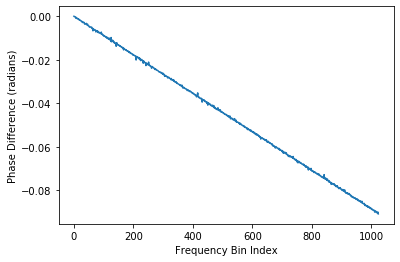

In [10]:
# Testing that shifting is working in frequency domain
# Phase difference
phase_diff = s0f_phase - s1f_phase
#plt.plot(phase_diff)

# Fix phase wrap issue
phase_diff = np.unwrap(phase_diff)
phase_diff = np.unwrap(phase_diff)
plt.plot(phase_diff)
plt.xlabel("Frequency Bin Index")
plt.ylabel("Phase Difference (radians)")

# Slope
slope = np.polyfit(range(sig_size), phase_diff, 1)[0] # square bracket 0 selects slope
print("slope = ", slope)

In [11]:
# Compare slope to time shift
print("delta_t_samples",delta_t_samples)
#print("slope = ",slope)
time_from_slope = slope/(2*np.pi/sig_size)
print("time_from_slope = ",time_from_slope)

delta_t_samples -0.014443749011598528
time_from_slope =  -0.014439685354242018


In [12]:
# Function that generates random element signals 
def random_sig_generator (sig_size):
    n = sig_size
    # New signal in time domain
    s0t = np.random.rand(n)-0.5 + 1.0j*np.random.rand(n)-0.5j
    # fourier
    s0f = np.fft.fft(s0t)
    return s0f
    
def time_shift_sig (s0f, delta_t_samples):
    n = len(s0f)
    # Time shift in Fourier Domain
    s1f = s0f*np.exp(-1.0j*(2*np.pi)*delta_t_samples*np.array(range(n))/n)
    return s1f
    
# function to add random noise
def random_noise(s0f, noise_sigma):
    n = len(s0f)
    s0f += (np.random.normal(size = n) + 1.0j*np.random.normal(size = n))*noise_sigma
    return s0f

def calc_time_from_slope(s0f, s1f):
    s0f_amplitude = np.abs(s0f)
    s1f_amplitude = np.abs(s1f)
    s0f_phase = np.angle(s0f) ;  s0f_phase = np.unwrap(s0f_phase)
    s1f_phase = np.angle(s1f) ;  s1f_phase = np.unwrap(s1f_phase)
    
    # Testing that shifting is working in frequency domain
    # Phase difference
    phase_diff = s0f_phase - s1f_phase
    #plt.plot(phase_diff)

    # Fix phase wrap issue
    phase_diff = np.unwrap(phase_diff)
    phase_diff = np.unwrap(phase_diff)

    # Slope
    slope = np.polyfit(range(sig_size), phase_diff, 1)[0] # square bracket 0 selects slope
    #print("slope = ", slope)
    
    time_from_slope = slope/(2*np.pi/sig_size)
    return time_from_slope
    

## Generate many random signals for antenna

In [15]:
dataset = []


for i in range(num_of_sigs):
    random_angle = np.random.rand()*60*2 - 60
    delta_t = time_from_angle(random_angle) 
    print(random_angle, delta_t)
    # Transmitted signal, every element will be a time shifted copy of this signal plus a little noise
    s0f = random_sig_generator(sig_size) 
    # loop over number of elements
    # empty vector to label each copy of the signal for each element 
    sigs_from_elements = []
    for k in range(num_of_elements):
        s_k = np.copy(s0f)
        s_k = time_shift_sig(s_k, delta_t*k)
        s_k = random_noise(s_k, noise_sigma)
        s_k_amplitude = np.abs(s_k)
        s_k_phase = np.angle(s_k) ;  s_k_phase = np.unwrap(s_k_phase)
        sigs_from_elements.append(s_k)
        
        
    for m in range(num_of_elements-1):
        # square bracket 1 picks off s_k_phase, this loops goes through all adjacent pairs of elements
        #print(calc_time_from_slope(sigs_from_elements[m], sigs_from_elements[m+1]), end = '  ')
        pass
        
    #print()
        
    # might have to massage it but this is close to train NN
    dataset.append([random_angle, np.abs(sigs_from_elements), np.unwrap(np.angle(sigs_from_elements))])
    
#print(dataset)

-12.813641698055179 -0.00369890337819645
-3.4024800651654843 -0.000989844491578401
-18.40838355597458 -0.005266774818714026
6.911229769448454 0.002006911952430328
43.17162576240867 0.01141099452438781
33.348191976944435 0.009168436594343396
-52.13745881786753 -0.013167201213666647
-58.600651000344385 -0.014235793700044958
-14.038770388381863 -0.0040457724102346306
45.202081617386085 0.011834792991824779
55.547362342304 0.013752749489047868
-48.436190577574635 -0.01247892144758604
-17.491874838705343 -0.005012977162708619
31.132291843628053 0.00862289601145961
-43.14525872135782 -0.011405395756145052
33.77232032726097 0.009271315638274692
-33.85896978466006 -0.009292271521579252
-44.23750822722089 -0.011635287257159637
-44.25207772226256 -0.011638325382886774
12.526791962826877 0.0036174378017035957
-6.518827905165196 -0.0018934716536579633
16.058448211646095 0.004613488450191189
-21.35985734816397 -0.006074608740929001
-54.380394881826284 -0.013557738103366846
-52.75786826071307 -0.013

In [14]:
print(np.shape(sigs_from_elements))

(2, 1024)
